# Monkey Species Identification

## Business Problem: 
Conservation groups in wildlife protection areas have limited anti-poaching resources and need help focusing them on the most effective areas. They have motion-triggered cameras set up throughout the conservation zone, which capture too many photos each day to be reviewed by hand. Not all species are targeted by poachers, and not all species are equally at risk. They need an automated process to identify whether a monkey is in each photo, and to identify the species of each monkey identified. They can combine this data with location and timing information from each photo to decide how to use anti-poaching resources most effectively.


## Technical Issues + Constraints
We have only a small dataset for training and validation (~150 images per class), and the budget for this project is limited. This constrains machine size, training time, and ability to obtain additional human labeled data. 

## Strategy
To solve the business problem under these constraints, we will use Transfer Learning to adapt pre-trained models which perform very well on the ImageNet task (https://www.image-net.org/challenges/LSVRC/) to the Monkey Species classification problem.


## Prerequisites: Download and Merge Datasets


### Setup
Create a directory to contain the images. The remainder of the "Prerequisite" steps should be completed from within this directory.

### Monkey Species Images
Most data comes from https://www.kaggle.com/slothkong/10-monkey-species. These 10 monkey species are the main classification targets. Download and extract the `training` and `validation` folders. Rename `training` to `train` and `validation` to `val`.

### Generic Wildlife Images
The rest of the data comes from https://www.kaggle.com/virtualdvid/oregon-wildlife. All of these images will be given the same label `nm` (for "**N**ot a **M**onkey"), because the wildlife cameras will be capturing photos not involving monkeys as well. Download and extract the full `oregon-wildlife` folder into the image directory.

### Merge

Create subdirectories `train/nm` and `val/nm`.

Run the script `dataclean.py` to move images from the `oregon_wildlife/<class-name>` directory into the `training/nm` and `val/nm` directories. We use a small number of images to keep class sizes balanced.

If you need to re-run this script, remove daty from the `nm` folders first because the script will add new images without replacing old images (resulting in imbalanced classes). 

The training/analysis pipelines are not designed with imbalanced classes in mind.

## Step 1: Import Libraries and Data, Set Variables

In [2]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision, torch
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

from tensorflow import keras
from tensorflow.keras import layers

from pytorch_transfer_learn import initialize_model, get_data_sets, train_model, set_training_mode, display_confusion_matrix, get_input_size
from keras_transfer_learn import load_data_sets, load_model

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.9.0
Torchvision Version:  0.10.0


In [3]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = "/mnt/e/flatiron/project5/image"

# Number of classes in the dataset
num_classes = 11

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

retrain = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Step 2: Train Pytorch Models


### Reference
The code in this section (and `pytorch_transfer_learn.py`) is adapted from https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html#helper-functions with the following changes:
* Multi-class output instead of binary output (which means changing loss fn, accuracy metric, etc.)
* Trains 6 models instead of a single model
* Saves models after training (and loads instead of retraining if `retrain == False`
* Pytorch Ignite is used for visualizing results using a confusion matrix


### Analysis Note
This training is done as a preliminary investigation in order to decide whether to invest more time in improving a Pytorch or Keras based approach for the final model. Some typical model evaluation metrics and training graphs are left out because they are unnecessary for this decision.

/home/mengyujackson121/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


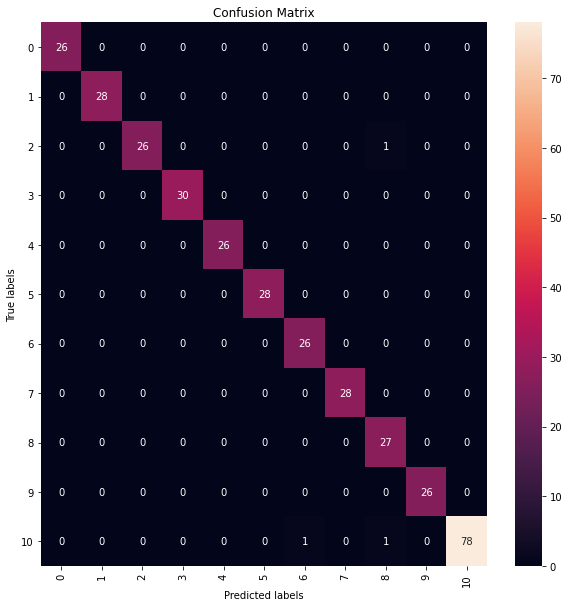

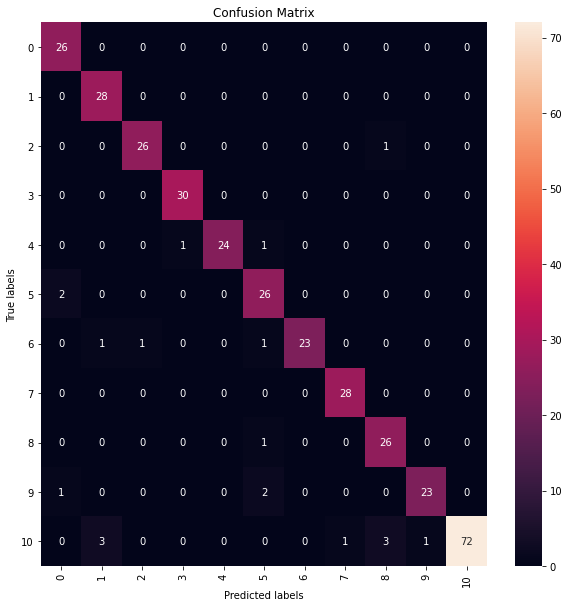

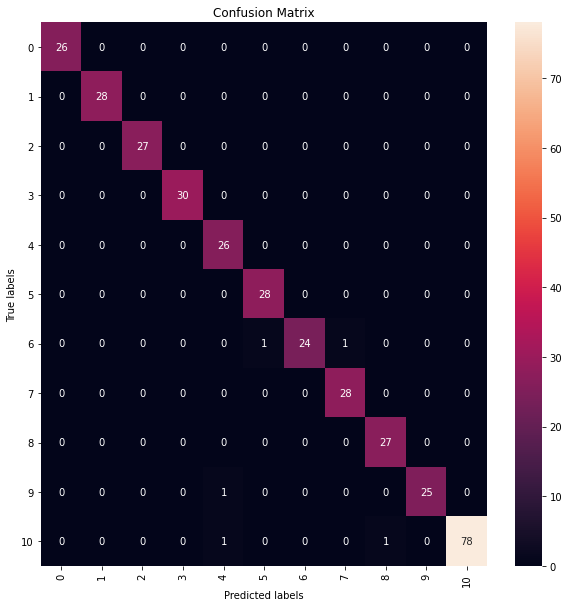

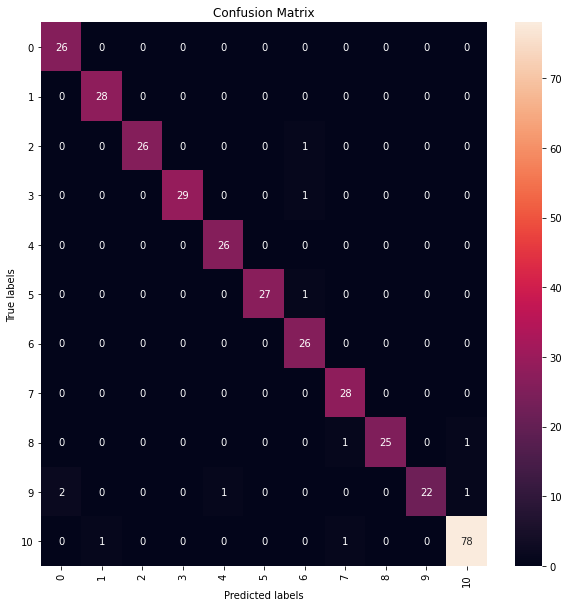

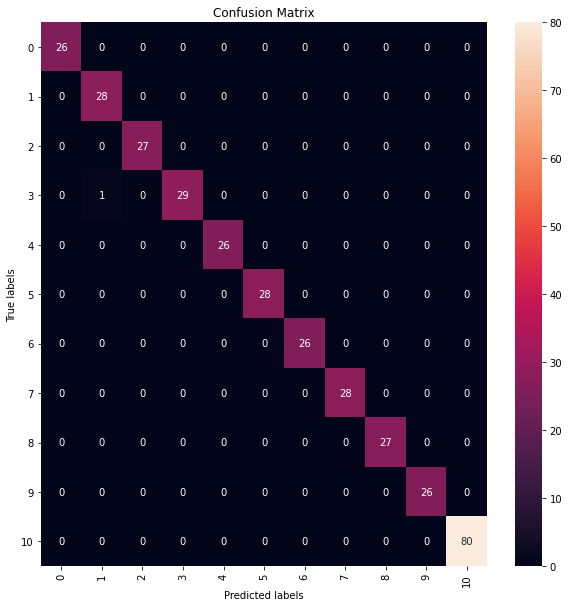

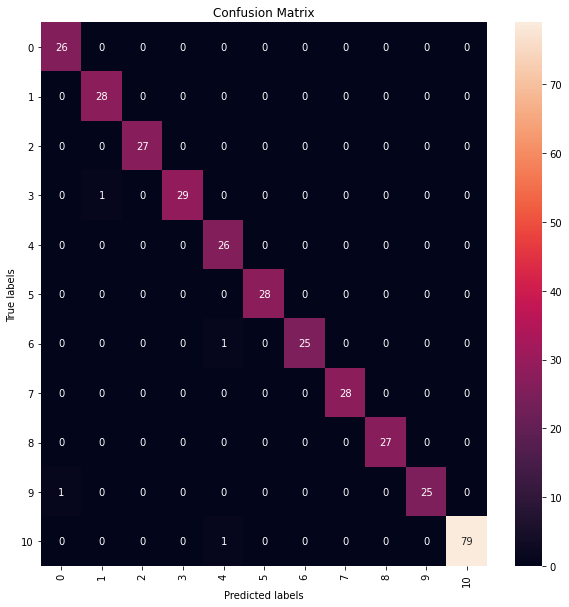

In [5]:
torch_models = {}

for model_name in ["resnet", "alexnet", "vgg", "squeezenet", "densenet", "inception"]:

    if not retrain:
        try:
            load_failed = False
            input_size = get_input_size(model_name)
            dataloaders_dict = get_data_sets(input_size, data_dir, batch_size)
            torch_models[model_name] = torch.load(f"{model_name}.pt")
        except Exception as e:
            print(f"Could not load model {model_name} due to {e}")
              load_failed = True
            
    if retrain or load_failed:
        # Initialize the model for this run
        torch_models[model_name], input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
        dataloaders_dict = get_data_sets(input_size, data_dir, batch_size)

        # Print the model we just instantiated
        print(torch_models[model_name])
        optimizer_ft = set_training_mode(torch_models[model_name], feature_extract, device)

        # Detect if we have a GPU available
        # Setup the loss fxn
        criterion = nn.CrossEntropyLoss()

        # Train and evaluate
        model_ft, hist = train_model(torch_models[model_name], dataloaders_dict, criterion, optimizer_ft, device, num_epochs=num_epochs, is_inception=(model_name=="inception"))
        torch.save(torch_models[model_name], f"{model_name}.pt")

    
    display_confusion_matrix(torch_models[model_name], device, dataloaders_dict)

## Pytorch Results
DenseNet clearly outperforms all other Pytorch models, incorrectly classifying only 1 image in the validation set. The model proves robust in the face of monkeys facing away from the camera, multiple monkeys, poor lighting, monkeys facing away from the camera, and monkeys of different ages (juveniles often look different from adults).

## Keras Training
### Reference
The code in this section (and `keras_transfer_learn.py`) is adapted from https://keras.io/guides/transfer_learning/ with the following changes:
* Multi-class output instead of binary output (which means changing loss fn, accuracy metric, etc.)
* 300x300 img size (similar to largest Pytorch Model) rather than 150x150
* Saves models after training (and loads instead of retraining if `retrain == False`
* Fixed Training and Validation directories are used to match Pytorch setup

In [6]:
batch_size = 32
img_height = 300
img_width = 300

In [7]:
train_ds, val_ds = load_data_sets(data_dir, img_height, img_width, batch_size)

Found 1197 files belonging to 11 classes.
Found 352 files belonging to 11 classes.


In [9]:
# Load models if retrain is False and one is available, otherwise transfer learn from `xception` base model
if not retrain:
    try:
        load_failed = False
        model = keras.models.load_model("xception.keras")
    except Exception as e:
        print("Could not load model due to", e)
        load_failed = True
        
if retrain or load_failed:
    model = load_model("xception", 11)

    model.summary()

    model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.CategoricalAccuracy()],
)

    model.fit(train_ds, epochs=num_epochs, validation_data=val_ds)
    model.save("xception.keras")

In [10]:
# Find some interesting images: 
#   The "best" and "worst" correctly labeled images in each class
#   All incorrectly classified images 

val_batches = val_ds.take(-1)
incorrect_image_label_predlabels = []
correct_good_image_by_label = {}
correct_bad_image_by_label = {}

for val_batch in val_batches:
    for i in range(len(val_batch[0])):
        image = val_batch[0][i] 
        y_prob = model.predict(np.expand_dims(image, axis=0))
        y_prob_max = max(y_prob[0])
        pred_label = y_prob.argmax(axis=-1)
        label = list(val_batch[1][i]).index(1.)
        # Add all bad labels to bad labelled image list
        if pred_label != label:
            incorrect_image_label_predlabels.append((image, label, pred_label, y_prob))
        # Only keep the "best" example for each category
        else:
            if correct_good_image_by_label.get(label, (0, -1e10))[1] < y_prob_max:
                correct_good_image_by_label[label] = (image, y_prob_max)
            if correct_bad_image_by_label.get(label, (0, 1e10))[1] > y_prob_max:
                correct_bad_image_by_label[label] = (image, y_prob_max)


<Figure size 432x288 with 0 Axes>

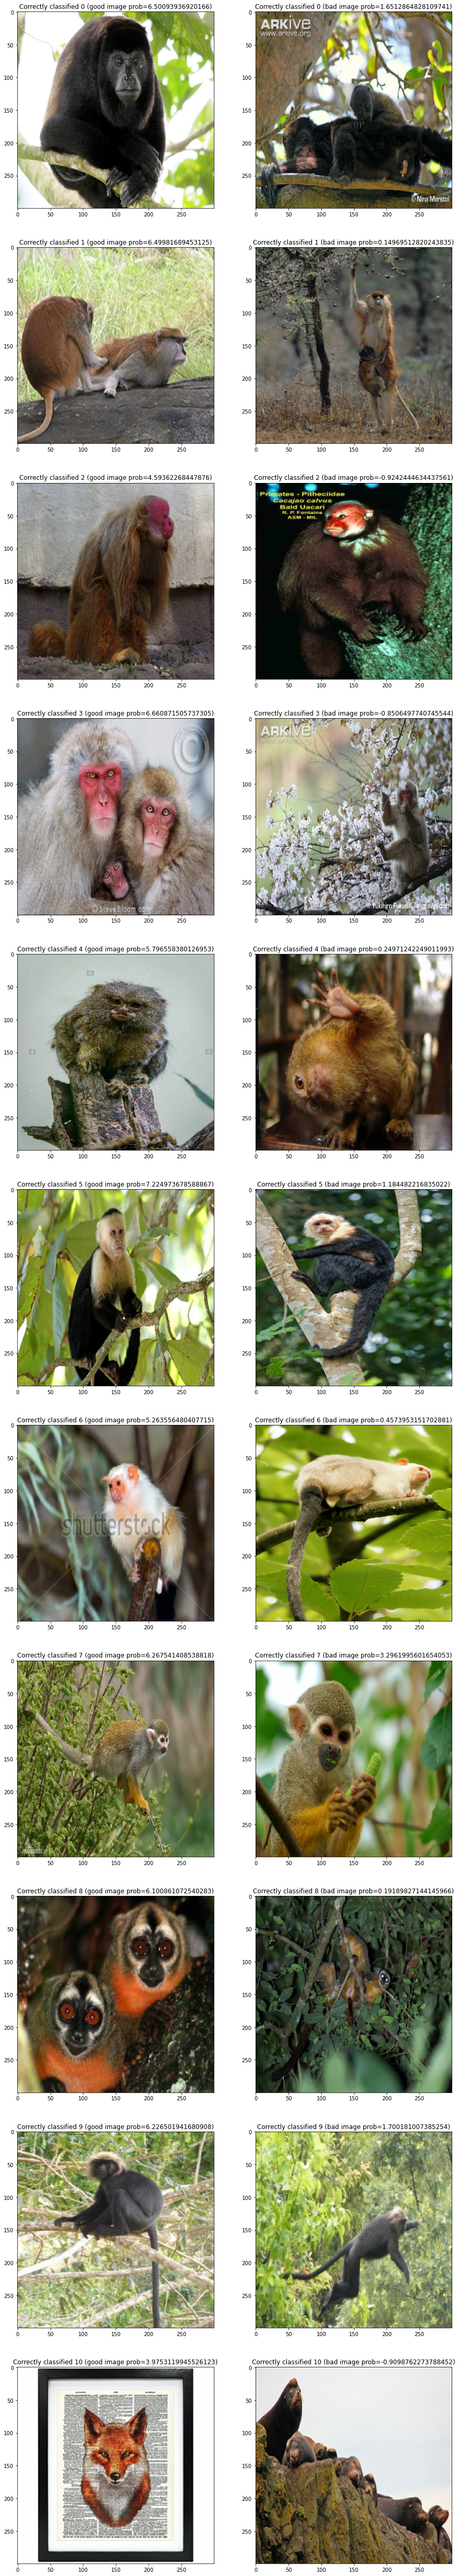

In [11]:
plt.figure()
f, axarr = plt.subplots(11, 2, figsize=(15, 90))
for i, key in enumerate(range(11)):
    row = i
    left_image, left_y_prob = correct_good_image_by_label[key]
    axarr[row][0].imshow(left_image/255)
    axarr[row][0].title.set_text(f"Correctly classified {key} (good image prob={left_y_prob})")
    
    right_image, right_y_prob = correct_bad_image_by_label[key]
    axarr[row][1].imshow(right_image/255)
    axarr[row][1].title.set_text(f"Correctly classified {key} (bad image prob={right_y_prob})")

y_prob=array([[-6.5822287 , -5.9483624 , -0.48101765, -2.5651813 , -3.2837985 ,
        -3.504218  ,  0.00769033, -6.244528  , -5.130213  , -4.2236943 ,
        -5.295012  ]], dtype=float32)


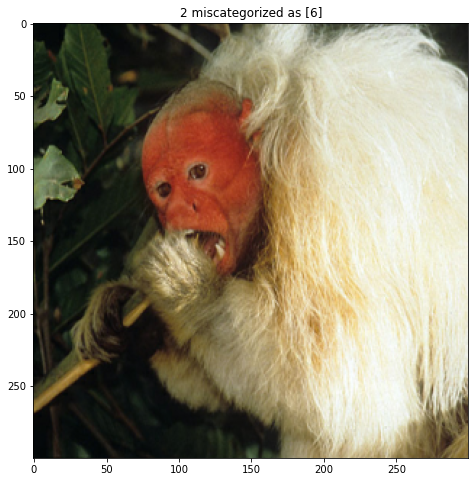

In [12]:
plt.figure(figsize=(8,8))
for i, tup in enumerate(incorrect_image_label_predlabels):
    col = i % 2
    image, label, pred_label, y_prob = tup
    plt.imshow(image/255)
    print(f"{y_prob=}")
    plt.title(f"{label} miscategorized as {pred_label}")


## Keras Results
The keras model performs equally to the best Pytorch Model, incorrectly classifying only 1 image.  The model proves robust in the face of monkeys facing away from the camera, multiple monkeys, poor lighting, monkeys facing away from the camera, and monkeys of different ages (juveniles often look different from adults).

The single mis-classified image is an individual with a unusual coat color for his species (white instead of brown), incorrectly classified as a species which has a typically white coat color. The second highest class probability for this image is correct, showing the model does see traits associated with both species in this image.

# Overall Results + Recommendation

## Overall Result
The current accuracy of the Keras model or the Pytorch is sufficient for our client. The model proves robust in the face of monkeys facing away from the camera, multiple monkeys, poor lighting, monkeys facing away from the camera, and monkeys of different ages (juveniles often look different from adults).

Because they get different samples wrong, and each has an extremely high degree of validation accuracy, it is difficult at this time to select a single model or measure improvement from additional training.


## Recommendation
We recommend running both the Pytorch and Keras Models for inference, and using human review only when they disagree. If models are found to be wrong (or disagree) often, we recommend investing in further model development at that time (likely just additional training data).